<a href="https://colab.research.google.com/github/akhandait/advanced-machine-learning-with-neural-networks-homeworks/blob/main/homeworks/hw1_problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 1 | Problem 4

In [ ]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

## Implementing a Convolutional Neural Network for Classification

Define a convolutional neural network with a dense top ...

In [3]:
import torch
import deeplay as dl

In [4]:
cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1, hidden_channels=[16, 32], out_channels=64,
        pool=torch.nn.MaxPool2d(kernel_size=2), out_activation=torch.nn.ReLU,
    ),
    dl.Layer(torch.nn.MaxPool2d, kernel_size=2),
    dl.Layer(torch.nn.Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64, hidden_features=[32, 32], out_features=1,
        out_activation=torch.nn.Identity,
    ),
)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
    )
  )
  (1): Layer[MaxPool2d](kernel_size=2)
  (2): Layer[Flatten]()
  (3): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=2304, out_features=32, bias=True)
        (activa

... and compile it for a regression task.

In [5]:
from torchmetrics import MeanAbsoluteError as MAE

cnn_regressor_template = dl.Regressor(
    model=cnn, loss=torch.nn.MSELoss(), optimizer=dl.Adam(), metrics=[MAE()],
)
cnn_ann_regressor = cnn_regressor_template.create()

print(cnn_ann_regressor)

Regressor(
  (loss): MSELoss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MeanAbsoluteError): MeanAbsoluteError(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64,

## Simulating the Training Data

Define the particle ...

In [8]:
image_size = 51

In [6]:
import deeptrack as dt

particle = dt.scatterers.MieSphere(
    position=lambda: np.random.uniform(image_size / 2 - 5,
                                       image_size / 2 + 5, 2),
    z=lambda: np.random.uniform(-1, 1),
    radius=lambda: np.random.uniform(400, 800) * 1e-9,
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)

/usr/local/lib/python3.11/dist-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


... specify the optical device to image the particle ...

In [9]:
brightfield_microscope = dt.optics.Brightfield(
    wavelength=630e-9, NA=0.8, resolution=1e-6, magnification=15,
    refractive_index_medium=1.33, output_region=(0, 0, image_size, image_size),
)

... combine them ...

In [10]:
imaged_particle = brightfield_microscope(particle)

... and plot them.

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def plot_simulated_particles(image_pipeline):
    """Plot simulated particles."""
    fig, axs = plt.subplots(1, 6, figsize=(25, 8))
    for i, ax in enumerate(axs.flatten()):
        image = image_pipeline.update().resolve()
        ax.imshow(np.squeeze(image), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

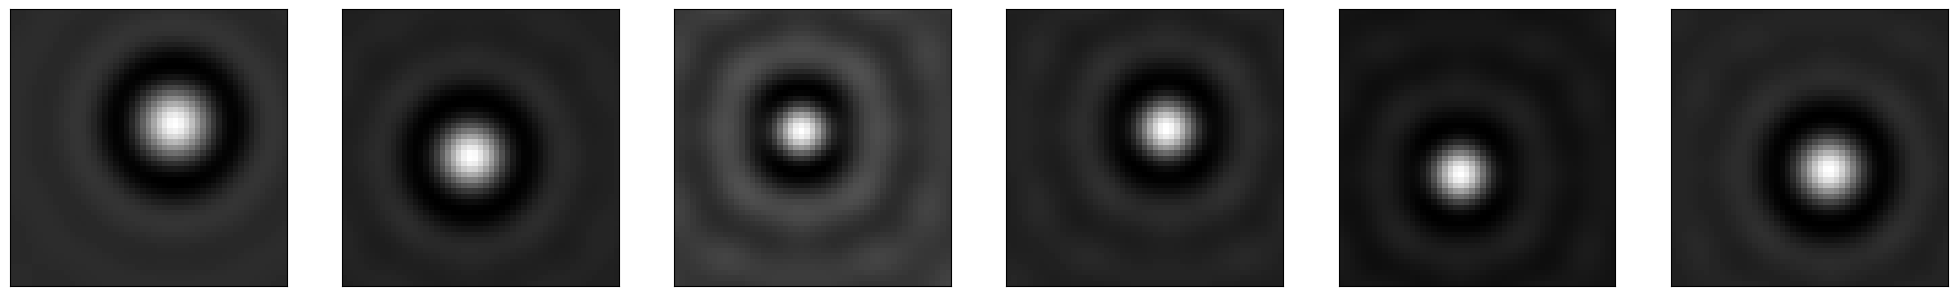

In [16]:
plot_simulated_particles(imaged_particle)

### Creating Images of Particles with Noise

Adding a Poisson noise source to the simulation pipeline ...

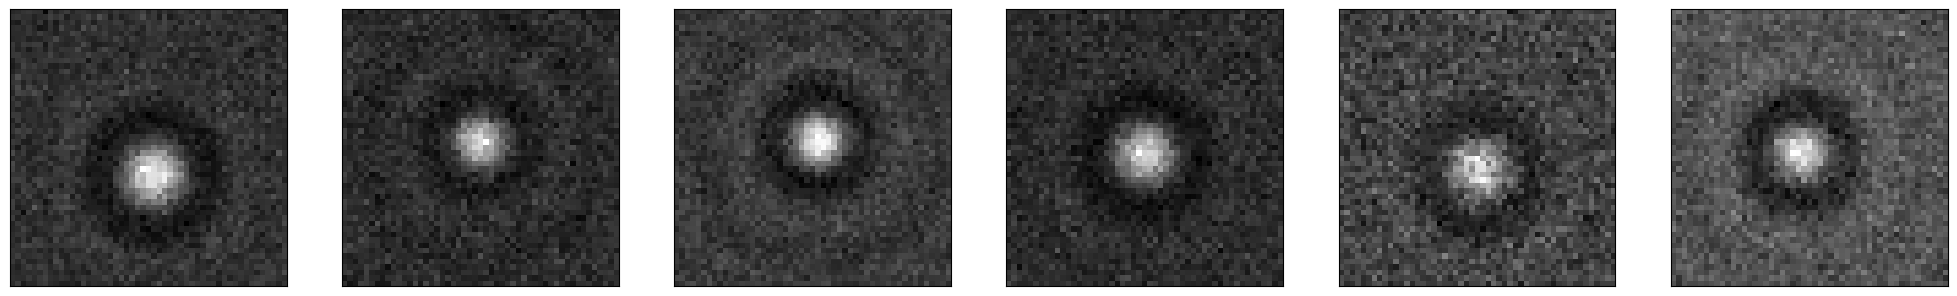

In [17]:
noise = dt.Poisson(
    min_snr=5, max_snr=20, background=1,
    snr=lambda min_snr, max_snr: np.random.uniform(min_snr, max_snr),
)
noisy_imaged_particle = imaged_particle >> noise

plot_simulated_particles(noisy_imaged_particle)

... and create a pipeline that generates noisy particle images and normalize the pixel values.

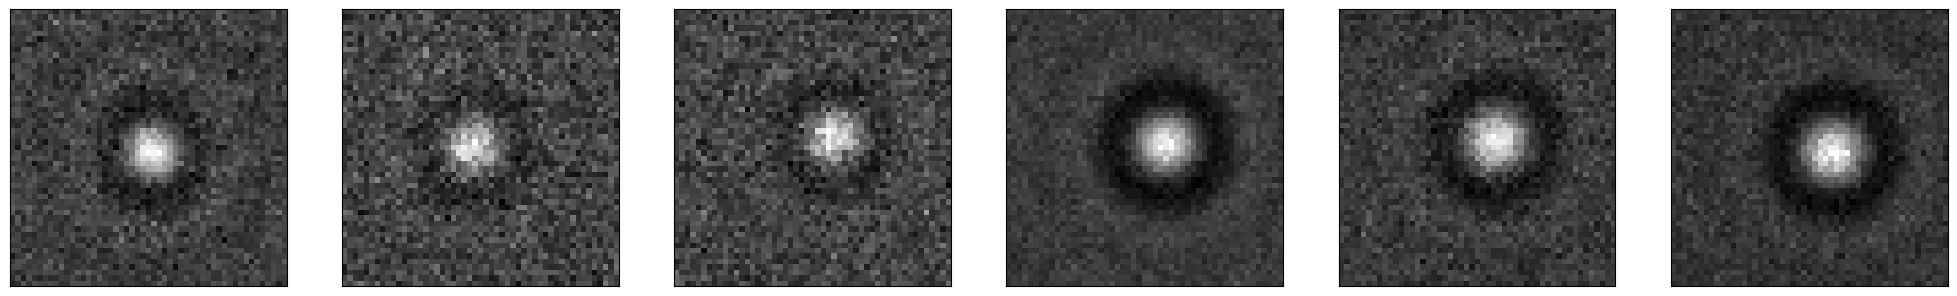

In [18]:
normalization = dt.NormalizeMinMax(lambda: np.random.uniform(0.0, 0.2),
                                   lambda: np.random.uniform(0.8, 1.0))
image_pipeline = noisy_imaged_particle >> normalization

plot_simulated_particles(image_pipeline)

### Getting the Positions from the Simulated Images

Define a pipeline to obtain both the particle image and its centroid position ...

In [19]:
pipeline = image_pipeline & particle.radius

### Preprocessing the Simulated Data

Create a database to work with the simulated particle images ...

In [27]:
class SimulatedDataset(torch.utils.data.Dataset):
    """Dataset with simulated particles."""

    def __init__(self, pipeline, data_size):
        """Initialize simulated dataset."""
        images, radii = [], []
        for _ in range(data_size):
            image, radius = pipeline.update().resolve()
            images.append(image), radii.append(radius)
        self.images, self.radii = np.array(images), np.array(radii)

    def __len__(self):
        """Return number of images."""
        return self.images.shape[0]

    def __getitem__(self, idx):
        """Get next simulated image and position."""
        im = torch.tensor(self.images[idx]).float().permute(2, 0, 1)
        rad = torch.tensor(self.radii[idx] * 1e7).float().unsqueeze(-1)
        return [im, rad]

... and create the training and test data loaders.

In [28]:
train_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=pipeline, data_size=25000), batch_size=64,
)
test_sim_dataloader = dl.DataLoader(
    SimulatedDataset(pipeline=pipeline, data_size=500), batch_size=32,
)

## Training the Neural Network with Simulated Data

In [29]:
cnn_sim_regressor = cnn_regressor_template.create()
cnn_sim_trainer = dl.Trainer(max_epochs=50, accelerator="auto")
cnn_sim_trainer.fit(cnn_sim_regressor, train_sim_dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | MSELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 98.1 K | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
98.1 K    Trainable params
0         Non-trainable params
98.1 K    Total params
0.393     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

### Testing the Trained Neural Network

In [30]:
test_sim_results = cnn_sim_trainer.test(cnn_sim_regressor, test_sim_dataloader)
MAE_sim = test_sim_results[0]["testMeanAbsoluteError_epoch"] * image_size
print(f"Mean pixel error (MAE): {MAE_sim:.3f} pixels")

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMeanAbsoluteError_epoch │     0.21099673211574554     │
│       test_loss_epoch       │     0.06772557646036148     │
└─────────────────────────────┴─────────────────────────────┘

Mean pixel error (MAE): 10.761 pixels


### Plotting the Predictions Versus the Ground Truth

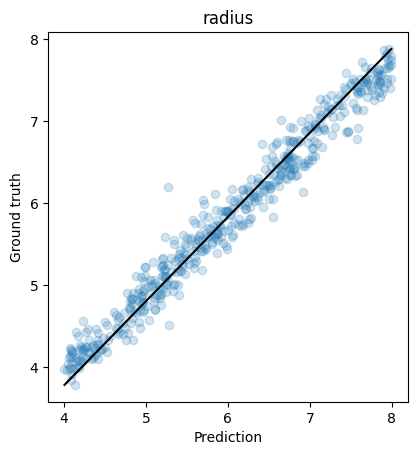

In [33]:
preds, gts = [], []
for image, radius in iter(test_sim_dataloader):
    preds.append(cnn_sim_regressor(image))
    gts.append(radius)

pred = torch.cat(preds, dim=0).detach().numpy()
gt = torch.cat(gts, dim=0).numpy()

fig, ax = plt.subplots()
ax.scatter(gt, pred, alpha=0.2)
ax.plot([np.min(gt), np.max(gt)], [np.min(pred), np.max(pred)], c="k")
ax.set_title(f"radius")
ax.set_xlabel("Prediction")
ax.set_ylabel("Ground truth")
ax.set_aspect("equal")
ax.label_outer()

plt.show()

### Comparing with the Annotated Data

In [ ]:
test_ann_results_with_cnn_sim = \
    cnn_sim_trainer.test(cnn_sim_regressor, test_ann_dataloader)
MAE_ann_with_cnn_sim = (test_ann_results_with_cnn_sim[0]
                        ["testMeanAbsoluteError_epoch"] * image_size)
print(f"Mean pixel error (MAE): {MAE_ann_with_cnn_sim:.3f} pixels")

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMeanAbsoluteError_epoch │     0.00532966572791338     │
│       test_loss_epoch       │    4.256179818185046e-05    │
└─────────────────────────────┴─────────────────────────────┘

Mean pixel error (MAE): 0.272 pixels


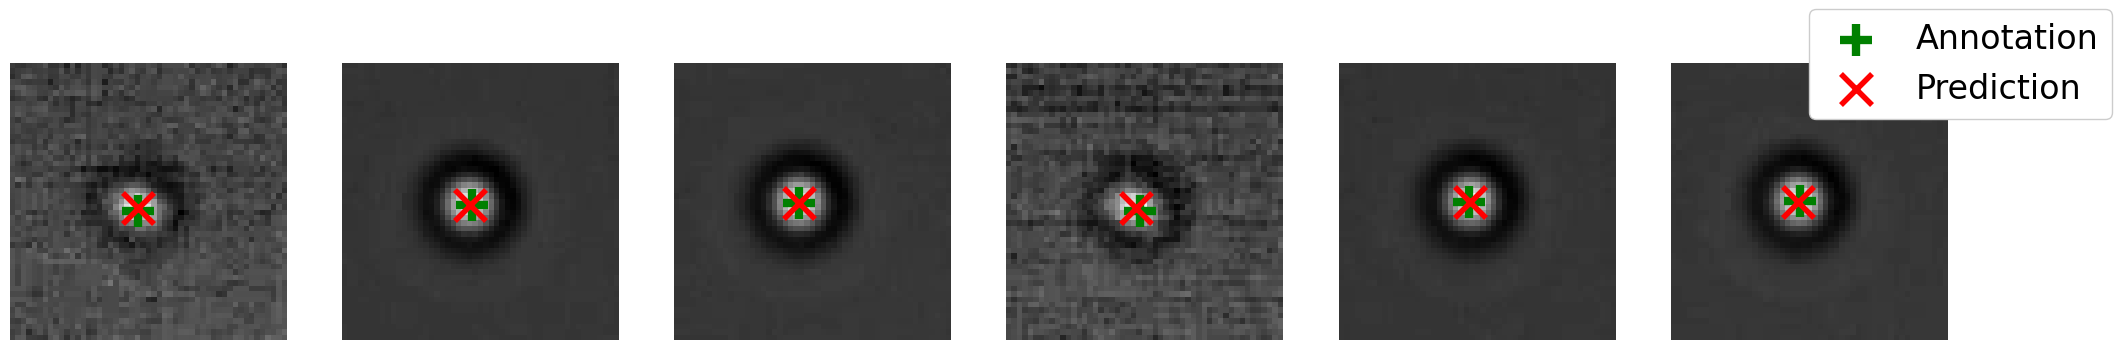

In [ ]:
indices = np.random.choice(np.arange(len(test_ann_dataset)), 6, replace=False)
images = [test_ann_dataset[index][0] for index in indices]
annotations = [test_ann_dataset[index][1] for index in indices]
predictions = cnn_sim_regressor(torch.stack(images))

fig, axs = plt.subplots(1, 6, figsize=(25, 8))
for ax, im, ann, pred in zip(axs, images, annotations, predictions):
    ax.imshow(im.numpy().squeeze(), cmap="gray")

    ann = ann * image_size + image_size / 2
    ax.scatter(ann[0], ann[1], marker="+", c="g", s=500, linewidth=6,
               label="Annotation")

    pred = pred.detach().numpy() * image_size + image_size / 2
    ax.scatter(pred[0], pred[1], marker="x", c="r", s=500, linewidth=4,
               label="Prediction")

    ax.set_axis_off()
ax.legend(loc=(0.5, 0.8), framealpha=1, fontsize=24)
plt.show()